In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace, GenerationConfig
from flash_ansr.refine import ConvergenceError
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'v7.0'
CHECKPOINT = ''

In [3]:
nsr = FlashANSR.load(
    directory=get_path('models', 'ansr-models', MODEL, CHECKPOINT),
    generation_config=GenerationConfig(method='softmax_sampling', temperature=1, top_p=0.95, choices=2048),
    n_restarts=8,
    parsimony=0.3,
    device=device
)

In [4]:
demo_expression = [
    ('x1**2 + 2*x1 + 1', (2, 1), (1, 5)),
    ('-x + log(x + x**4)', None, (1, 5)),
    ('0.1 * ((1.1 / x)**(12) - (1.2 / x)**6)', (0.1, 1.1, 1.2), (0.8, 2.5)),
    ('5.3 / (1.0 + exp(0.72 * (x - 2.85)))', (5.3, 1, 0.72, 2.85), (-10, 10)),
    ('5.3 / (1.0 + exp(0.72 * (x - 2.85))) + sin(1.5 * x)', (5.3, 1, 0.72, 2.85, 1.5), (-10, 10)),
][1]

In [5]:
expression, constants, xlim = demo_expression

In [6]:
prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
code = codify(code_string, nsr.expression_space.variables + constants_names)

if constants is None:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
else:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

In [7]:
x = np.random.uniform(*xlim, 100)
y = demo_function(x)
if isinstance(y, float):
    y = np.full_like(x, y)

print(x.shape, y.shape)

(100,) (100,)


# Before

In [8]:
nsr.fit(
    x,
    y,
    verbose=True)

Fitting Constants: 100%|██████████| 1196/1196 [00:04<00:00, 278.70it/s]


In [9]:
nsr.get_expression()

'-1.56 * sin((-4.36 * pow1_4(x1)) - -4.57)'

In [10]:
x_linspace = np.linspace(*xlim, 1000)
y_linspace_pred = nsr.predict(x_linspace.reshape(-1, 1))

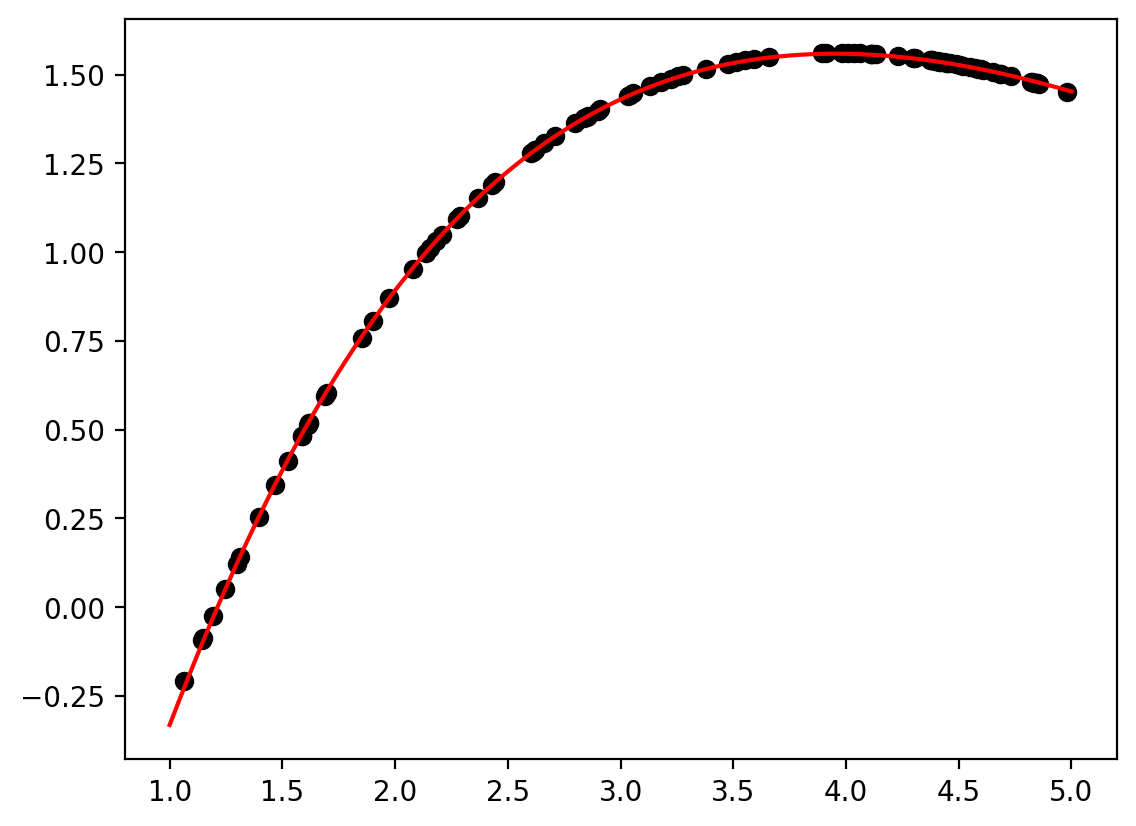

In [11]:
fig, ax = plt.subplots(dpi=200)

ax.scatter(x, y, label='Data', color='black')
ax.plot(x_linspace, y_linspace_pred, label='Prediction', color='red')

# Specialize

In [12]:
nsr.specialize(
    x,
    y,
    generation_config=GenerationConfig(method='softmax_sampling', temperature=1, top_p=0.95, choices=1000),
    parsimony=0.3,
    priority_queue_size=10,
    entropy_weight=0.005,
    verbose=True)

Specializing:  24%|██▍       | 240/1000 [19:06<1:00:30,  4.78s/it, NLL=2.90e-02, H=2.77e-01, Max Queue Objective=-2.2, Min Queue Objective=-2.2, Min FVU=1.21e-05, Explored=9106, Best Expression=cos(pow1_4(<num> + x1) / <num>) / <num>]


KeyboardInterrupt: 

In [13]:
histories = {k: [log[k] for log in nsr.specialize_history] for k in nsr.specialize_history[0]}

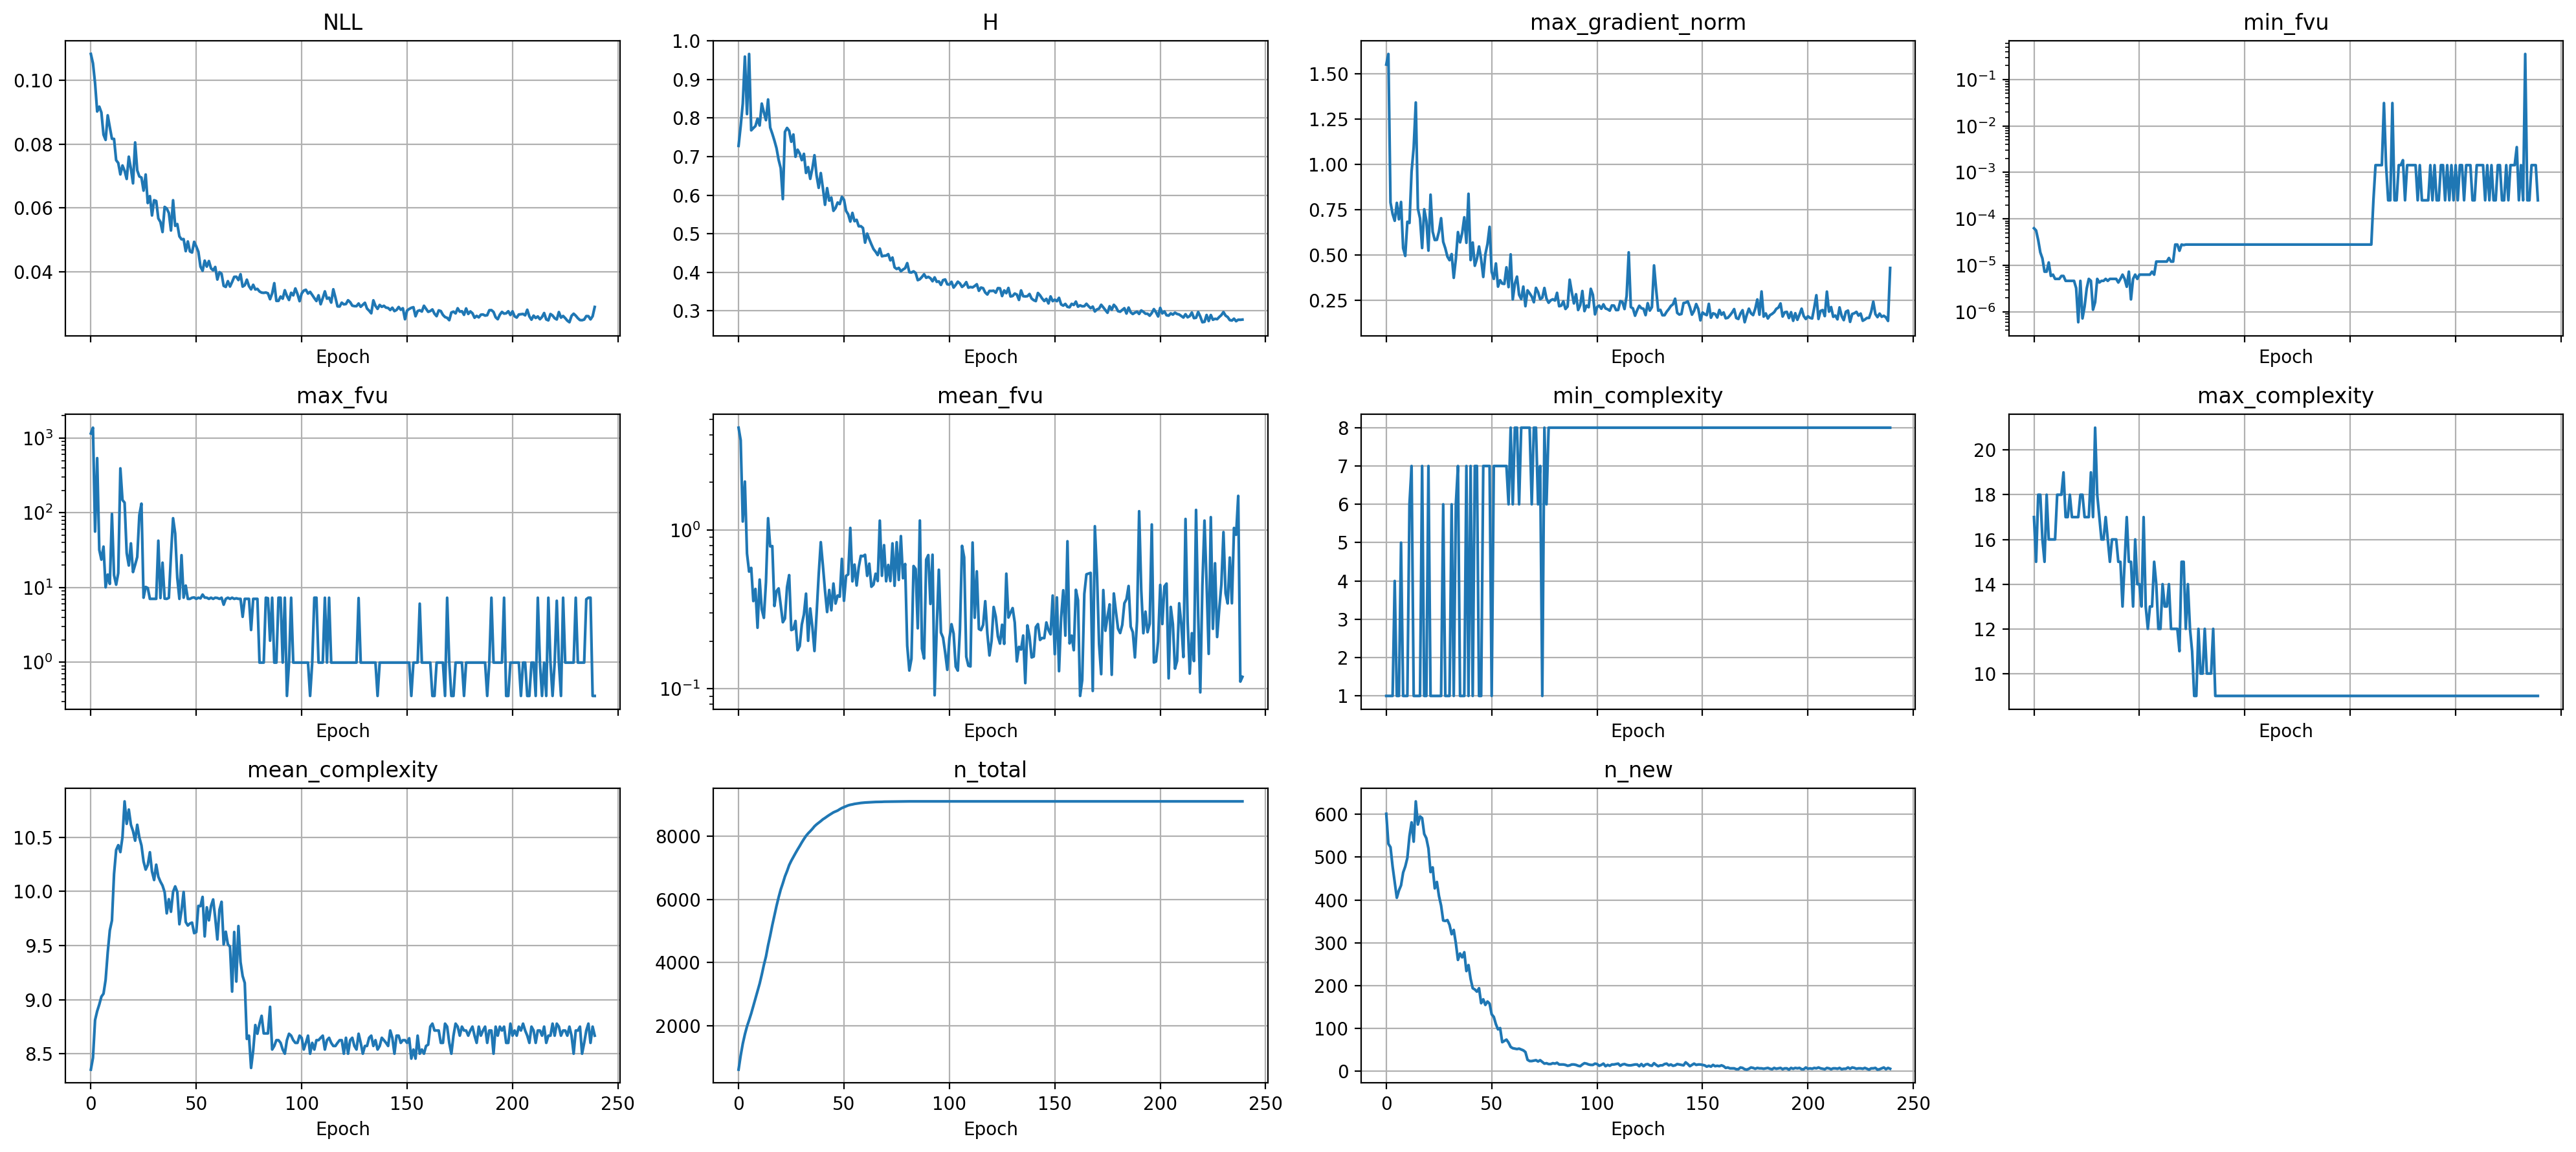

In [14]:
COLS = 4
ROWS = np.ceil(len(histories) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(5 * COLS, 3 * ROWS), dpi=200, sharex=True)

for ax, (k, v) in zip(axes.flat, histories.items()):
    valid_v = [x for x in v if np.isfinite(x)]
    ax.plot(range(len(v)), v)
    ax.set_xlabel('Epoch')
    ax.set_title(k)
    ax.grid()

    if 'fvu' in k:
        ax.set_yscale('log')

    if max(valid_v) > 10000:
        ax.set_ylim(None, 10000)

for ax in axes.flat[len(histories):]:
    ax.axis('off')

fig.tight_layout()

# After

In [15]:
nsr.fit(
    x,
    y,
    verbose=True)

Fitting Constants: 100%|██████████| 20/20 [00:00<00:00, 178.37it/s]


In [16]:
nsr.get_expression()

'1.56 * cos(pow1_4(0.06 + x1) / -0.23)'

In [17]:
x_linspace = np.linspace(*xlim, 1000)
y_linspace_pred = nsr.predict(x_linspace.reshape(-1, 1))

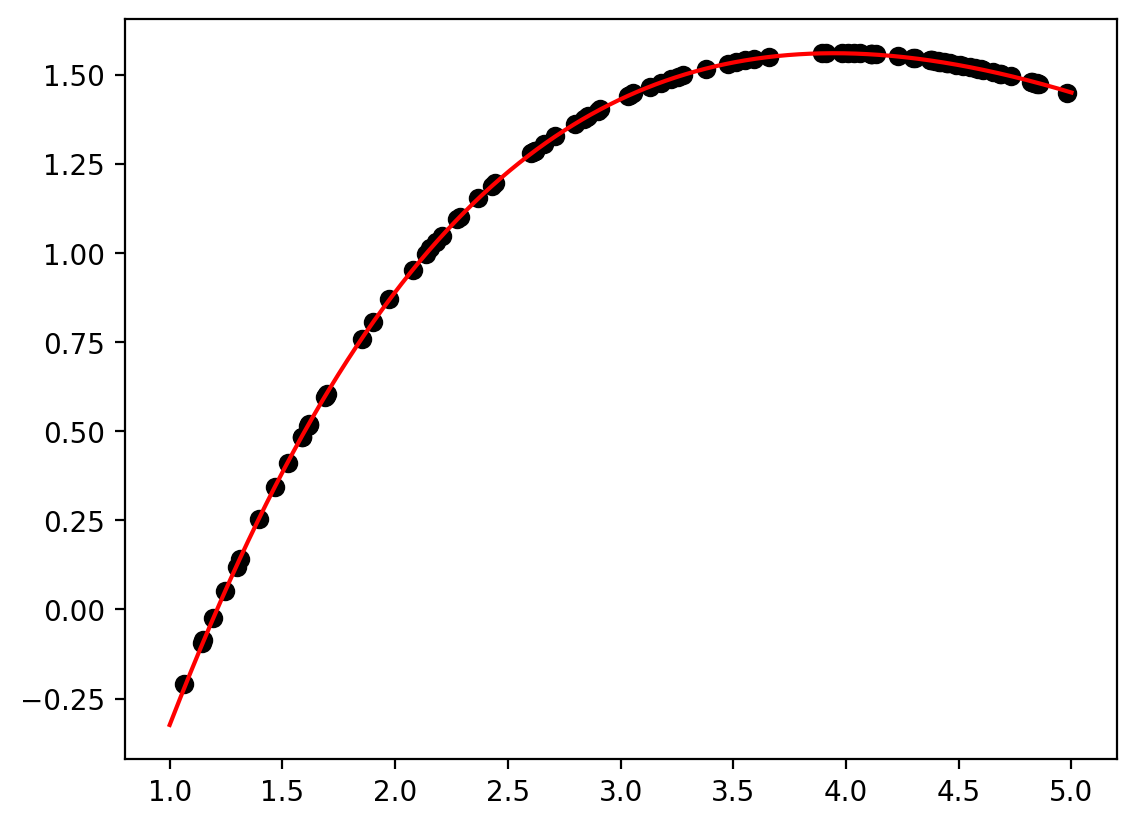

In [18]:
fig, ax = plt.subplots(dpi=200)

ax.scatter(x, y, label='Data', color='black')
ax.plot(x_linspace, y_linspace_pred, label='Prediction', color='red')

In [19]:
nsr.results

,log_prob,fvu,score,expression,complexity,target_complexity,numeric_prediction,raw_beam,beam,raw_beam_decoded,function,refiner,beam_id,fit_constants,fit_covariances,fit_loss
0,-2.463713,0.000012,-2.217682,"[*, <num>, cos, /, pow1_4, +, <num>, x1, <num>]",9,None,None,"[1, 10, 6, 23, 11, 20, 7, 6, 30, 6, 2]","[10, 6, 23, 11, 20, 7, 6, 30, 6]","[*, <num>, cos, /, pow1_4, +, <num>, x1, <num>]",<function <lambda> at 0x7f50e70cde40>,"Refiner(expression=['*', '<num>', 'cos', '/', ...",0,"[1.5601116383208016, 0.05581122924568582, -0.2...","[[4.390122184818718e-08, -1.6903278569340156e-...",0.000003
1,-2.463713,0.000012,-2.217682,"[*, <num>, cos, /, pow1_4, +, <num>, x1, <num>]",9,None,None,"[1, 10, 6, 23, 11, 20, 7, 6, 30, 6, 2]","[10, 6, 23, 11, 20, 7, 6, 30, 6]","[*, <num>, cos, /, pow1_4, +, <num>, x1, <num>]",<function <lambda> at 0x7f50e70cde40>,"Refiner(expression=['*', '<num>', 'cos', '/', ...",0,"[1.5953186213151664, 2.6597756173882288, -0.12...","[[1.6064970603472676e-05, -4.1175257615359646e...",0.000905
2,-2.463713,0.000012,-2.217682,"[*, <num>, cos, /, pow1_4, +, <num>, x1, <num>]",9,None,None,"[1, 10, 6, 23, 11, 20, 7, 6, 30, 6, 2]","[10, 6, 23, 11, 20, 7, 6, 30, 6]","[*, <num>, cos, /, pow1_4, +, <num>, x1, <num>]",<function <lambda> at 0x7f50e70cde40>,"Refiner(expression=['*', '<num>', 'cos', '/', ...",0,"[-1.5724904804421003, -0.9386977206514864, 0.4...","[[0.00018649311822734272, -0.00010559980614618...",0.004247
3,-2.463713,0.000012,-2.217682,"[*, <num>, cos, /, pow1_4, +, <num>, x1, <num>]",9,None,None,"[1, 10, 6, 23, 11, 20, 7, 6, 30, 6, 2]","[10, 6, 23, 11, 20, 7, 6, 30, 6]","[*, <num>, cos, /, pow1_4, +, <num>, x1, <num>]",<function <lambda> at 0x7f50e70cde40>,"Refiner(expression=['*', '<num>', 'cos', '/', ...",0,"[-1.5724898692729032, -0.9386988331900583, -0....","[[0.0001865020138069187, -0.000105608819809023...",0.004247
4,-2.463713,0.000012,-2.217682,"[*, <num>, cos, /, pow1_4, +, <num>, x1, <num>]",9,None,None,"[1, 10, 6, 23, 11, 20, 7, 6, 30, 6, 2]","[10, 6, 23, 11, 20, 7, 6, 30, 6]","[*, <num>, cos, /, pow1_4, +, <num>, x1, <num>]",<function <lambda> at 0x7f50e70cde40>,"Refiner(expression=['*', '<num>', 'cos', '/', ...",0,"[-1.5724906723877679, -0.9386973708481278, -0....","[[0.00018649026603296726, -0.00010559693913346...",0.004247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,-5.078969,0.990000,2.695635,"[*, <num>, cos, /, pow1_5, -, x1, <num>, <num>]",9,None,None,"[1, 10, 6, 23, 11, 21, 8, 30, 6, 6, 2]","[10, 6, 23, 11, 21, 8, 30, 6, 6]","[*, <num>, cos, /, pow1_5, -, x1, <num>, <num>]",<function <lambda> at 0x7f50e70ce5c0>,"Refiner(expression=['*', '<num>', 'cos', '/', ...",19,"[-1.6955434413498824, 0.9819187920684477, 0.46...","[[0.0009121034291705562, 0.0003463919391213035...",0.007234
150,-5.078969,0.990000,2.695635,"[*, <num>, cos, /, pow1_5, -, x1, <num>, <num>]",9,None,None,"[1, 10, 6, 23, 11, 21, 8, 30, 6, 6, 2]","[10, 6, 23, 11, 21, 8, 30, 6, 6]","[*, <num>, cos, /, pow1_5, -, x1, <num>, <num>]",<function <lambda> at 0x7f50e70ce5c0>,"Refiner(expression=['*', '<num>', 'cos', '/', ...",19,"[-1.6955438382962957, 0.9819184671571697, 0.46...","[[0.0009120941589128511, 0.0003463859805208726...",0.007234
151,-5.078969,0.990000,2.695635,"[*, <num>, cos, /, pow1_5, -, x1, <num>, <num>]",9,None,None,"[1, 10, 6, 23, 11, 21, 8, 30, 6, 6, 2]","[10, 6, 23, 11, 21, 8, 30, 6, 6]","[*, <num>, cos, /, pow1_5, -, x1, <num>, <num>]",<function <lambda> at 0x7f50e70ce5c0>,"Refiner(expression=['*', '<num>', 'cos', '/', ...",19,"[-1.6955352966721227, 0.9819254558976277, 0.46...","[[0.0009122923877643997, 0.0003465132931520319...",0.007234
152,-5.078969,0.990000,2.695635,"[*, <num>, cos, /, pow1_5, -, x1, <num>, <num>]",9,None,None,"[1, 10, 6, 23, 11, 21, 8, 30, 6, 6, 2]","[10, 6, 23, 11, 21, 8, 30, 6, 6]","[*, <num>, cos, /, pow1_5, -, x1, <num>, <num>]",<function <lambda> at 0x7f50e70ce5c0>,"Refiner(expression=['*', '<num>', 'cos', '/', ...",19,"[1.211003244235809, -265.69630588986166, -1980